# Introducción a uso de API para SISSA

## Documentación de acceso programático (API) y ejemplos en lenguaje R

#### Daniel Bonhaure (danielbonhaure@gmail.com)
#### Santiago Rovere (srovere@gmail.com)
#### Guillermo Podestá (gpodesta@rsmas.miami.edu)
#### *30 de octubre de 2020*


# Introducción

El presente documento tiene como propósito proveer algunos ejemplos de uso de la API de SISSA. El público al cual está destinado este documento está conformado por desarrolladores de software, programadores científicos o investigadores interesados en acceder a algunos de los datos del CRC-SAS. En cualquier caso, se asume que el lector tiene conocimientos previos de programación.

Este documento contiene solamente ejemplos de algunos de los servicios implementados en la API. Antes de comenzar a leer este documento, se recomienda haber leído previamente alguno de los manuales de referencia con ejemplos en R y Python:

* R: https://github.com/CRC-SAS/web-services-R
* Python: https://github.com/CRC-SAS/web-services-python



# Pasos previos

En primer lugar, se procederá a la instalación de los paquetes que van a ser necesarios y que no han sido provistos por la instalación estándar de Python. 


In [ ]:
import sys

# Función que permite verificar la existencia de un entorno virtual
def is_venv():
    return (hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

# Verificar entorno virtual
if not is_venv():
    print("Considere utilizar un entorno virtual. Vea el archivo setup.sh en este mismo repositorio.")

# Instalar modulos necesarios
!python -m pip install wheel
!python -m pip install setuptools
!python -m pip install jupyterlab
!python -m pip install netCDF4
!python -m pip install python-dateutil
!python -m pip install pandas
!python -m pip install seaborn
!python -m pip install tabulate
!python -m pip install requests
!python -m pip install statsmodels
!python -m pip install https://github.com/matplotlib/basemap/archive/master.zip
!python -m pip install ipyleaflet
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-leaflet
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Luego definiremos algunas funciones de uso común que nos permitan agilizar la programación. Estas funciones además permitirán que el usuario no tenga que implementar por su cuenta algunas partes del código, por ejemplo la obtención de los datos, la autenticación o la conversión de los datos de salida a un formato que permita una sencilla manipulación subsiguiente de los mismos.

Se comenzará por cargar todos los paquetes de Python necesarios para poder ejecutar el código y los ejemplos provistos en adelante.


In [1]:
# Carga de paquetes Python necesarios para hacer los requests a la API y graficar resultados
import pathlib
import dateutil
import dateutil.parser
import pandas.testing
import pandas.plotting
import requests
import requests.auth
import seaborn
import datetime
import calendar
import os
import netCDF4
import json
import math
import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import ipyleaflet
import statsmodels.api as sm
from mpl_toolkits.basemap import Basemap
from IPython.display import HTML

Luego, indicaremos al paquete `matplotlib` que los gráficos van a ser generados en un notebook.

In [2]:
%matplotlib inline  

A continuación, definiremos un set de funciones útiles en lenguaje Python que le permitirán al usuario acceder a la API de una forma más sencilla, sin tener que detenerse en detalles como la autenticación o la conversión de datos devueltos.

In [3]:
# Definición de funciones globales, en lenguaje Python.
# Función para acceder a un servicio web definido por una URL utilizando el método GET.
# Devuelve la respuesta como un pandas.DataFrame.
def consumir_servicio_GET(url, usuario, clave):
    respuesta = requests.get(url=url, auth=requests.auth.HTTPBasicAuth(usuario, clave))
    return respuesta


# Función para acceder a un servicio web definido por una URL utilizando el método POST.
# Devuelve la respuesta como un pandas.DataFrame.    
def consumir_servicio_POST(url, usuario, clave, data):
    respuesta = requests.post(url=url, data=data, auth=requests.auth.HTTPBasicAuth(usuario, clave))
    return respuesta


# Función para acceder a un servicio web definido por una URL utilizando
# un usuario y clave.
# Asumiendo que la respuesta es un string JSON, se hace la conversión
# de este string a un Data Frame.
def consumir_servicio_JSON(url, usuario, clave):
    respuesta = consumir_servicio_GET(url, usuario, clave)
    return pandas.json_normalize(respuesta.json())


# Función para acceder a un servicio web definido por una URL utilizando un usuario y clave.
# Se envía un archivo GeoJSON para realizar la consulta en un área determinada.
# La respuesta se devuelve con un objeto de tipo raster.
def consumir_servicio_espacial(url, usuario, clave, archivo_geojson_zona, raster_var_tag):
    # a. Obtener datos y guardarlos en un archivo temporal (en memoria)
    zona_geojson = pathlib.Path(archivo_geojson_zona).read_text()
    respuesta = consumir_servicio_POST(url, usuario, clave, json.dumps({'zona.geojson': zona_geojson}))

    # b. En lugar de abrir y leer un archivo, se leen los bytes recibidos
    archivo_nc = netCDF4.Dataset("in-mem-file", mode="r", memory=respuesta.content)

    # c. Obtener CRS y fechas del NetCDF
    nc_prj4string = archivo_nc.crs
    nc_start_date = np.array([dateutil.parser.isoparse(archivo_nc.start_date)])
    nc_variable = archivo_nc.variables.get('time')
    nc_fechas = netCDF4.num2date(nc_variable[:].flatten(), nc_variable.units) if nc_variable else nc_start_date
    nc_rasters = archivo_nc.variables.get(raster_var_tag)[:]  # rasters como variables netcdf

    # d. Borrar archivo temporal, liberar memoria
    archivo_nc.close()

    return nc_fechas, nc_rasters  # los rasters se devuelven como variables netcdf


# Funciones para el manejo de péntadas
# Determina a qué pentada del año corresponde una fecha (1-72)
def fecha_a_pentada_año(fecha: datetime):
    dia = fecha.day
    mes = fecha.month
    pentada_mes = 6 if dia > 25 else ( (dia - 1) // 5 ) + 1
    return int(pentada_mes + 6 * (mes - 1))


# Determina a qué pentada del mes corresponde una fecha (1-6)
def fecha_a_pentada_mes(fecha: datetime):
  pentada_año = fecha_a_pentada_año(fecha)
  return int(((pentada_año - 1) % 6) + 1)


# Devuelve la fecha de inicio de una péntada de un añó determinado
def pentada_año_a_fecha_inicio(pentada_año: int, año: int):
    pentada_mes = ((pentada_año - 1) % 6) + 1
    dia = 1 + 5 * (pentada_mes - 1)
    mes = ((pentada_año - 1) // 6) + 1
    return datetime.datetime(int(año), int(mes), int(dia))


# Obtener la fecha de inicio de péntada de una fecha determinada
def fecha_inicio_pentada(fecha: datetime):
   pentada_mes = fecha_a_pentada_mes(fecha)
   dia_inicio = 1 + 5 * (pentada_mes - 1)
   return datetime.datetime(fecha.year, fecha.month, int(dia_inicio))


# Obtener la fecha de fin de péntada de una fecha determinada
def fecha_fin_pentada(fecha: datetime):
    pentada_mes = fecha_a_pentada_mes(fecha)
    _, days_in_month = calendar.monthrange(fecha.year, fecha.month)
    dia_fin = 5 + 5 * (pentada_mes - 1) if pentada_mes < 6 else days_in_month
    return datetime.datetime(fecha.year, fecha.month, int(dia_fin))


Además, a efecto de poder probar los ejemplos de esta documentación, se definen las siguientes variables (los datos de usuario y clave se encuentran ocultos por cuestiones de seguridad y deberán ser solicitados a las instituciones miembros del CRC-SAS):

In [4]:
base_url        = 'https://api.crc-sas.org/ws-api'
usuario_default = 'generico'
clave_default   = 'gen141co'

La variable *base.url* representa la dirección URL base (Uniform Resource Locator [8]) común a todos los servicios. Cada servicio está unívocamente identificado por una URL que se construye a partir de la URL base y una ruta (o ubicación) asociada al mismo. Esta construcción se hace mediante la concatenación de la URL base y la ruta. Cada servicio asociado a un conjunto de datos puede ser identificado unívocamente por una ruta. Las diferentes rutas se describen más abajo. A modo de ejemplo, para acceder al servicio de datos sobre estaciones se tomará la URL base provisoria (https://api.crc-sas.org/ws-api) y se la concatenará con la ruta de dicho servicio (/estaciones) resultando en la URL completa para este servicio (https://api.crc-sas.org/ws-api/estaciones). Las variables *usuario.default* y *clave.default* son las credenciales de acceso necesarias para poder realizar la autenticación y obtener los datos buscados.

![Estructura de la URL](img/Estructura_URL.PNG)

## Casos de uso

A continuación se presentarán algunos problemas comunes y realistas a fin de ilustrar el uso de la API. Debe tenerse en cuenta que la elaboración de gráficos y mapas no forma parte del uso de la API, pero es parte necesaria para darle sentido al ejemplo.

### __Problema 1__: Geolocalizar todas las estaciones meteorológicas de Argentina en un mapa. Identificar la estación Pehuajó (ID OMM 87544) y todas las estaciones geográficamente vecinas que se encuentren dentro de un radio de 300 kilómetros.

Comenzamos por realizar la búsqueda de estaciones a través de la API. Esta es la porción de código correspondiente a la ejecución del servicio.


In [20]:
# 1. Búsqueda de estaciones de Argentina (AR, para otros países utilizar el código ISO de 2 letras correspondiente)
estaciones = consumir_servicio_JSON(url= base_url + "/estaciones/AR", 
                                    usuario=usuario_default, clave=clave_default)


# 2. Búsqueda de estaciones vecinas a Pehuajó (omm_id = 87544).
#    Se buscan estaciones dentro de un radio de 300km.
omm_central_id = 87544
maxima_distancia_km = 300
url_vecinas = f"{base_url}/estaciones_vecinas/{omm_central_id}?max_distancia={maxima_distancia_km}"
estaciones_vecinas = consumir_servicio_JSON(url=url_vecinas, 
                                            usuario=usuario_default, clave=clave_default)

# 3. Indico si la estación es Central (Pehuajó), Vecina u Otra
estaciones = estaciones.assign(
    tipo=lambda df: df.apply(
        lambda x: 'Central' if x['omm_id'] == omm_central_id else 'Vecina' if x['omm_id'] in estaciones_vecinas['omm_id'].values else 'Otra', axis=1)
)

HTML(estaciones.query('tipo != "Otra"').to_html(notebook=True, index=False))


omm_id,nombre,latitud,longitud,elevacion,nivel_adm1,nivel_adm2,tipo
87484,Pergamino INTA,-33.9300,-60.5500,65.0,Buenos Aires,Pergamino,Vecina
87537,General Villegas INTA,-34.9200,-62.7300,117.0,Buenos Aires,General Villegas,Vecina
87624,Anguil INTA,-36.5000,-63.9800,165.0,La Pampa,Capital,Vecina
87468,Venado Tuerto,-33.6823,-61.9614,113.0,Santa Fe,General López,Vecina
87532,General Pico Aero,-35.6882,-63.7595,145.0,La Pampa,Maracó,Vecina
87534,Laboulaye Aero,-34.1278,-63.3676,137.0,Córdoba,Presidente Roque Sáenz Peña,Vecina
87540,Trenque Lauquen,-35.9690,-62.7261,95.0,Buenos Aires,Trenque Lauquen,Vecina
87544,Pehuajó Aero,-35.8407,-61.8598,87.0,Buenos Aires,Pehuajó,Central
87548,Junín Aero,-34.5525,-60.9313,81.0,Buenos Aires,Junín,Vecina
87550,Nueve de Julio,-35.4390,-60.8819,76.0,Buenos Aires,Nueve de Julio,Vecina


Una vez obtenidos los datos de estaciones de Argentina y vecinas de Pehuajó a través de la API, se elabora el mapa pedido. En el mismo se marca la estación Pehuajó con un color diferente, así como a sus vecinas.

In [6]:
# Graficar con leaflet (no se exporta a html pero funciona en el notebook)
m = ipyleaflet.Map(basemap=ipyleaflet.basemaps.CartoDB.Positron, center=[-38.5, -64], zoom=4)

for e in estaciones.itertuples():
    if e.tipo == "Central":
        central_circle = ipyleaflet.Circle()
        central_circle.location = (e.latitud, e.longitud)
        central_circle.radius = 300000
        central_circle.weight = 2
        m.add_layer(central_circle)
    circle = ipyleaflet.Circle()
    circle.location = (e.latitud, e.longitud)
    circle.radius = 30000
    circle.stroke = False
    circle.fill_color = 'red' if e.tipo == 'Central' else 'orange' if e.tipo == 'Vecina' else 'green'
    circle.fill_opacity = 1.0
    m.add_layer(circle)

m

Map(center=[-38.5, -64], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

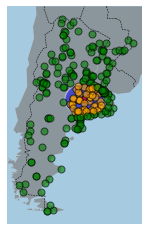

In [21]:
# Graficar usando matplotlib
ar_lon, ar_lat = -38.5, -64
m = Basemap(lon_0=ar_lon, lat_0=ar_lat, epsg=4326,
            llcrnrlat=-57, urcrnrlat=-20, llcrnrlon=-75, urcrnrlon=-52)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcountries(linestyle='--')

for e in estaciones.itertuples():
    if e.tipo == "Central":
        m.tissot(e.longitud, e.latitud, np.rad2deg(300/6367.), 256, facecolor='b', alpha=0.5)
    m.plot(e.longitud, e.latitud, linestyle='none', marker="o", markersize=7, alpha=0.6,
           c='red' if e.tipo == 'Central' else 'orange' if e.tipo == 'Vecina' else 'green',
           markeredgecolor="black", markeredgewidth=1)

plt.show()

### __Problema 2__: Buscar los valores de precipitación acumulada de 3 meses para los meses de *enero* a *marzo* de la estación Pehuajó. Utilizar el período de referencia 1971-2010 para ajustar una distribución no paramétrica a dichos valores.

Comenzamos por buscar los valores de precipitación acumulada de *enero* a *marzo* para Pehuajó (87544) dentro del período de referencia solicitado. Para el caso de la precipitación acumulada debemos buscar el estadístico *Suma* (existen otros estadísticos como la media, la mediana, etc) para un ancho de ventana de 3 meses (lo que equivale a 18 péntadas, que es la unidad mínima de movilidad de la ventana). El servicio devolverá el estadístico *Suma* para la variable de precipitaciones (única variable para la cual se calcula). Posteriormente debemos quedarnos solamente con datos de precipitaciones que comiencen en el 1 de enero y finalicen el 31 de marzo.

In [7]:
omm_id = 87544
ancho_ventana = 18
fecha_desde = dateutil.parser.parse("1971-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2010-12-31").isoformat()
url_estadisticas = f"{base_url}/estadisticas_moviles/{omm_id}/Suma/{ancho_ventana}/{fecha_desde}/{fecha_hasta}"

estadisticas = consumir_servicio_JSON(url=url_estadisticas, usuario=usuario_default, clave=clave_default)
estadisticas['fecha_desde'] = pd.to_datetime(estadisticas['fecha_desde'])
estadisticas['fecha_hasta'] = pd.to_datetime(estadisticas['fecha_hasta'])
estadisticas = estadisticas.query('fecha_hasta.dt.month == 3 and fecha_hasta.dt.day == 31')

Una vez obtenidos los 40 valores de precipitación acumulada de *enero* a *marzo* para el período de 1971-2010, realizamos el ajuste no paramétrico y generamos los conjuntos de datos necesarios para construir un histograma a partir de los datos originales, la función de densidad ajustada y un QQ-plot para comparar las distribuciones.

In [8]:
# Datos necesarios para el ajuste
tamano_bin = 50  # Ancho de cada intervalo
muestra_original = estadisticas['valor'].values

# 1. Histograma de datos originales
r_hist_counts, r_hist_breaks = np.histogram(muestra_original, bins=range(0, 900+1, tamano_bin))
r_hist_mids = 0.5 * (r_hist_breaks[1:] + r_hist_breaks[:-1])

# 2. Ajuste no paramétrico y cálculo de función de densidad
kde = sm.nonparametric.KDEUnivariate(muestra_original)
kde = kde.fit()  # Estimar densidades


Ahora procedemos a realizar los gráficos

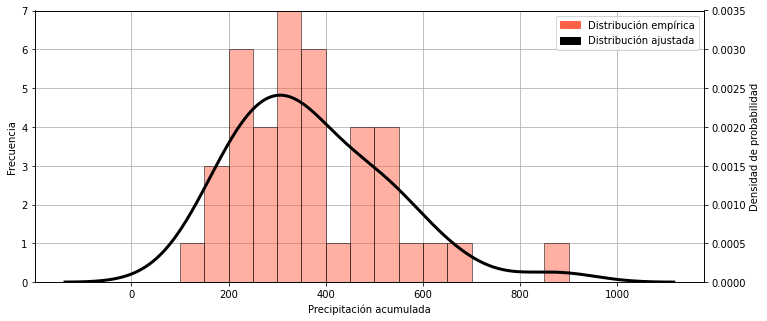

In [9]:
# Generar gráfico
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Graficar el histograma
ax.hist(muestra_original, bins=range(0, 900+1, tamano_bin),
        zorder=5, color='tomato', edgecolor='k', alpha=0.5)
ax.set_ylabel('Frecuencia')
ax.set_xlabel('Precipitación acumulada')
ax.grid(True, zorder=-5)
ax.set_ylim(0, 7)

# Graficar la función ajustada
ay = ax.twinx()
ay.plot(kde.support, kde.density, lw=3, zorder=10, color='black')
ay.set_ylabel('Densidad de probabilidad')
ay.set_ylim(0, 0.0035)

# Leyenda
emp_patch = mpatches.Patch(color='tomato', label='Distribución empírica')
kde_patch = mpatches.Patch(color='black', label='Distribución ajustada')
plt.legend(handles=[emp_patch, kde_patch])

plt.show()

### __Problema 3__: Obtener las series temporales de SPI-3 para Pehuajó (87544) calculado mediante un ajuste paramétrico de precipitaciones dentro del período de referencia 1971-2010, utilizando el método de máxima verosimilitud sin remuestreo. Graficar la serie para el período 2017-2019.

Para iniciar este proceso primero obtenemos el listado de configuraciones de índices y seleccionamos SPI con escala de 3 meses. Encontramos que el ID de configuración es el 43.

In [10]:
configuraciones = consumir_servicio_JSON(url=f"{base_url}/indices_sequia_configuraciones",
                                            usuario=usuario_default, clave=clave_default)
# Seleccionar SPI y escala de 3 meses
configuraciones = configuraciones.query('indice == "SPI" and escala == 3')

# Vista de las configuraciones en una tabla
HTML(configuraciones.to_html(notebook=True, index=False))

id,indice,escala,distribucion,metodo_ajuste,referencia_comienzo,referencia_fin,procesable
3,SPI,3,Gamma,NoParametrico,1971-01-01,2010-12-31,1
43,SPI,3,Gamma,ML-SinRemuestreo,1971-01-01,2010-12-31,1


Ahora procedemos a buscar la serie temporal de SPI-3 para Pehuajó entre 2017 y 2019.

In [11]:
omm_id = 87544
indice_configuracion_id = 43
fecha_desde = dateutil.parser.parse("2017-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-12-31").isoformat()
url_valores_indice = f"{base_url}/indices_sequia_valores/{indice_configuracion_id}/" \
                        f"{omm_id}/{fecha_desde}/{fecha_hasta}"
serie_temporal_spi = consumir_servicio_JSON(url=url_valores_indice,
                                            usuario=usuario_default, clave=clave_default)

# Definir la fecha de fin del período a partir del año y la péntada de fin
serie_temporal_spi = serie_temporal_spi.assign(
    fecha_fin_pentada=lambda df: df.apply(
        lambda x: fecha_fin_pentada(pentada_año_a_fecha_inicio(x['pentada_fin'], x['ano'])), axis=1)
)

Finalmente, se grafican los valores de SPI-3 y los valores de precipitación acumulada que dieron origen a dichos índices.

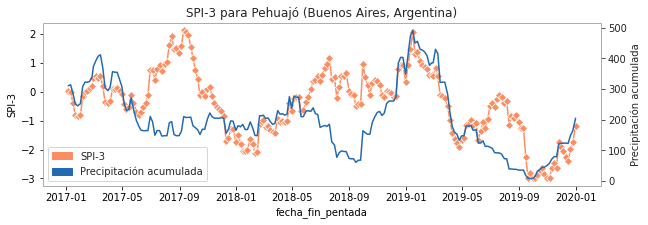

In [12]:
# Graficar
fig, ax = plt.subplots(figsize=(10, 3))

seaborn.set_style('whitegrid')

# Gráfico de spi
ax_spi = seaborn.lineplot(x=serie_temporal_spi.fecha_fin_pentada, y=serie_temporal_spi.valor_indice,
                            alpha=1., color='#fc8d62', marker="D", ax=ax)
ax_spi.set_ylabel('SPI-3')

# Gráfico de precipitación
ax_prcp = seaborn.lineplot(x=serie_temporal_spi.fecha_fin_pentada, y=serie_temporal_spi.valor_dato,
                            alpha=1., color='#226bb0', ax=ax.twinx())
ax_prcp.set_ylabel('Precipitación acumulada')
ax_prcp.grid(False)

# Labels
ax_plt = plt.gca()
ax_plt.set_title('SPI-3 para Pehuajó (Buenos Aires, Argentina)', fontsize='large')
ax_plt.set_xlabel('Fecha de fin del período')

# Legend
spi_patch = mpatches.Patch(color='#fc8d62', label='SPI-3')
prcp_patch = mpatches.Patch(color='#226bb0', label='Precipitación acumulada')
plt.legend(handles=[spi_patch, prcp_patch])

plt.show()

### __Problema 4__: Obtener el SPI-3 basado en CHIRPS para Uruguay. Los valores de SPI-3 deben corresponder al período enero a marzo de 2019.

El primer paso de la resolución consiste en descargar los datos de SPI-3 basados en CHIRPS. Para ello, debemos proveer un archivo GeoJSON que defina el área de interés a fin de acotar la descarga de datos. También debemos definir el período. En este caso, la fecha de inicio es igual a la fecha de fin porque se va a descargar una sola imagen.

In [13]:
fecha_desde = dateutil.parser.parse("2019-03-31").isoformat()
fecha_hasta = dateutil.parser.parse("2019-03-31").isoformat()
url_chirps = f"{base_url}/chirps/spi/3/{fecha_desde}/{fecha_hasta}"
fechas, rasters = consumir_servicio_espacial(url=url_chirps, usuario=usuario_default, clave=clave_default,
                                                archivo_geojson_zona="data/Uruguay.geojson", raster_var_tag='spi')

Ahora que ya descargamos el *raster* de SPI-3, se puede proyectar el mismo sobre un mapa.

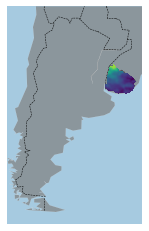

In [14]:
# Graficar rasters de CHIRPS.
ar_lon, ar_lat = -38.5, -64
m = Basemap(lon_0=ar_lon, lat_0=ar_lat, epsg=4326,
            llcrnrlat=-57, urcrnrlat=-20, llcrnrlon=-75, urcrnrlon=-52)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcountries(linestyle='--')

ax = plt.gca()
extent = [-58.6, -52.9, -35.15, -30]
ax.imshow(rasters[0], extent=extent, vmin=rasters.min(), vmax=rasters.max(), 
          zorder=3, cmap='viridis')

plt.axis('off')
plt.show()

### __Ejercicio de práctica__: Obtener las series temporales de SPI-3 para Durazno (Uruguay) (86530) y las estaciones geográficamente vecinas dentro de un radio de 150 kilómetros. Buscar los datos de SPI-3 calculado mediante un ajuste no paramétrico de precipitaciones dentro del período de referencia 1971-2010. Graficar las series para el período 2017-2019.

Este problema puede verse como una combinación de los problemas (1) y (3) planteados previamente. El primer paso consiste en encontrar las estaciones geográficamente vecinas a Durazno dentro de un radio de 150 kilómetros, para lo cual se procede de la siguiente manera:

In [15]:
# 1. Búsqueda de estaciones vecinas a Durazno (omm_id = 86530).
#    Se buscan estaciones dentro de un radio de 100km.
omm_central_id = 86530
max_distancia_km = 150
url_vecinas = f"{base_url}/estaciones_vecinas/{omm_central_id}?max_distancia={max_distancia_km}"
estaciones_vecinas = consumir_servicio_JSON(url=f"{url_vecinas}",
                                            usuario=usuario_default, clave=clave_default)

estaciones = estaciones_vecinas[['omm_id', 'nombre']]\
    .append({'omm_id': '86530', 'nombre': 'Durazno'}, ignore_index=True)

# Vista de estaciones vecinas en una tabla
HTML(estaciones.to_html(notebook=True, index=False))

omm_id,nombre
86460,Paso de los Toros
86545,Florida
86450,Young
86490,Mercedes
90000001,Las Brujas
86530,Durazno


El próximo paso debería ser buscar los datos de SPI-3 para las estaciones especificadas. Sin embargo, previamente a eso se debe buscar la configuración de cálculo correspondiente a SPI-3 ajustado de forma no paramétrico. Se procede entonces a realizar dicha búsqueda.

In [16]:
configuraciones = consumir_servicio_JSON(url=f"{base_url}/indices_sequia_configuraciones",
                                         usuario=usuario_default, clave=clave_default)
# Seleccionar SPI y escala de 3 meses
configuraciones = configuraciones.query('indice == "SPI" and escala == 3')

# Vista de las configuraciones en una tabla
HTML(configuraciones.to_html(notebook=True, index=False))

id,indice,escala,distribucion,metodo_ajuste,referencia_comienzo,referencia_fin,procesable
3,SPI,3,Gamma,NoParametrico,1971-01-01,2010-12-31,1
43,SPI,3,Gamma,ML-SinRemuestreo,1971-01-01,2010-12-31,1


Ya tenemos los ID OMM de las estaciones especificadas y el ID de la configuración de cálculo del índice. Ahora se procede a buscar los valores de SPI-3 pedidos de a una estación por vez.

In [17]:
series_temporales = pandas.DataFrame()
indice_configuracion_id = 3
fecha_desde = dateutil.parser.parse("2017-01-01").isoformat()
fecha_hasta = dateutil.parser.parse("2019-12-31").isoformat()

for estacion in estaciones.itertuples():
    # Ahora se define la URL para realizar la búsqueda
    url_valores_indice = f"{base_url}/indices_sequia_valores/{indice_configuracion_id}/" \
                            f"{estacion.omm_id}/{fecha_desde}/{fecha_hasta}"
    # Buscar serie temporal y agregar el nombre de la estacion (con ID)
    serie_temporal_spi = consumir_servicio_JSON(url=url_valores_indice,
                                                usuario=usuario_default, clave=clave_default)
    # Definir la fecha de fin del período a partir del año y la péntada de fin
    serie_temporal_spi = serie_temporal_spi.assign(
        fecha_fin_pentada=lambda df: df.apply(
            lambda x: fecha_fin_pentada(pentada_año_a_fecha_inicio(x['pentada_fin'], x['ano'])), axis=1)
    )
    # Agregar nombre para el gráfico
    serie_temporal_spi['nombre_completo'] = f"{estacion.nombre} ({estacion.omm_id})"

    # Agregar filas a data frame de todas las series temporales
    series_temporales = series_temporales.append(serie_temporal_spi, ignore_index=True)


Finalmente, se muestan las series temporales de SPI-3 en un gráfico.

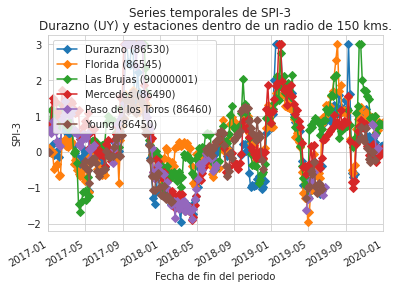

In [18]:
# Generar gráfico
series_temporales.set_index('fecha_fin_pentada', inplace=True)
series_temporales.groupby('nombre_completo')['valor_indice']\
    .plot(legend=True, xlim=('2017-01-01', '2020-01-01'), marker="D")\
    .map(lambda ax: ax.set(xlabel='Fecha de fin del periodo', ylabel='SPI-3'))
plt.suptitle('Series temporales de SPI-3')
plt.title('Durazno (UY) y estaciones dentro de un radio de 150 kms.')
plt.show()